# Using the Chula RL Library

## Goal:

- Familiarize yourself with Chula RL library which would ease your coding a lot

## Prerequisites

1. go to https://github.com/phizaz/chula_rl 
2. clone
3. cd to the cloned directory
4. `pip install -e .` to install in an editable mode
5. pull new updates frequently

In [1]:
import gym
import chula_rl as rl
import os
import numpy as np
import random
from collections import deque, defaultdict

## We provide many tools for rapid development

This would be a tutorial on how to incorporate a random agent.

Usually you'll need 3 things:

1. Environment 
1. Policy = define what kind of policy it is, how to train it
2. Explorer = define how an agent would interact with an environment

# An anatomy of RL training loop

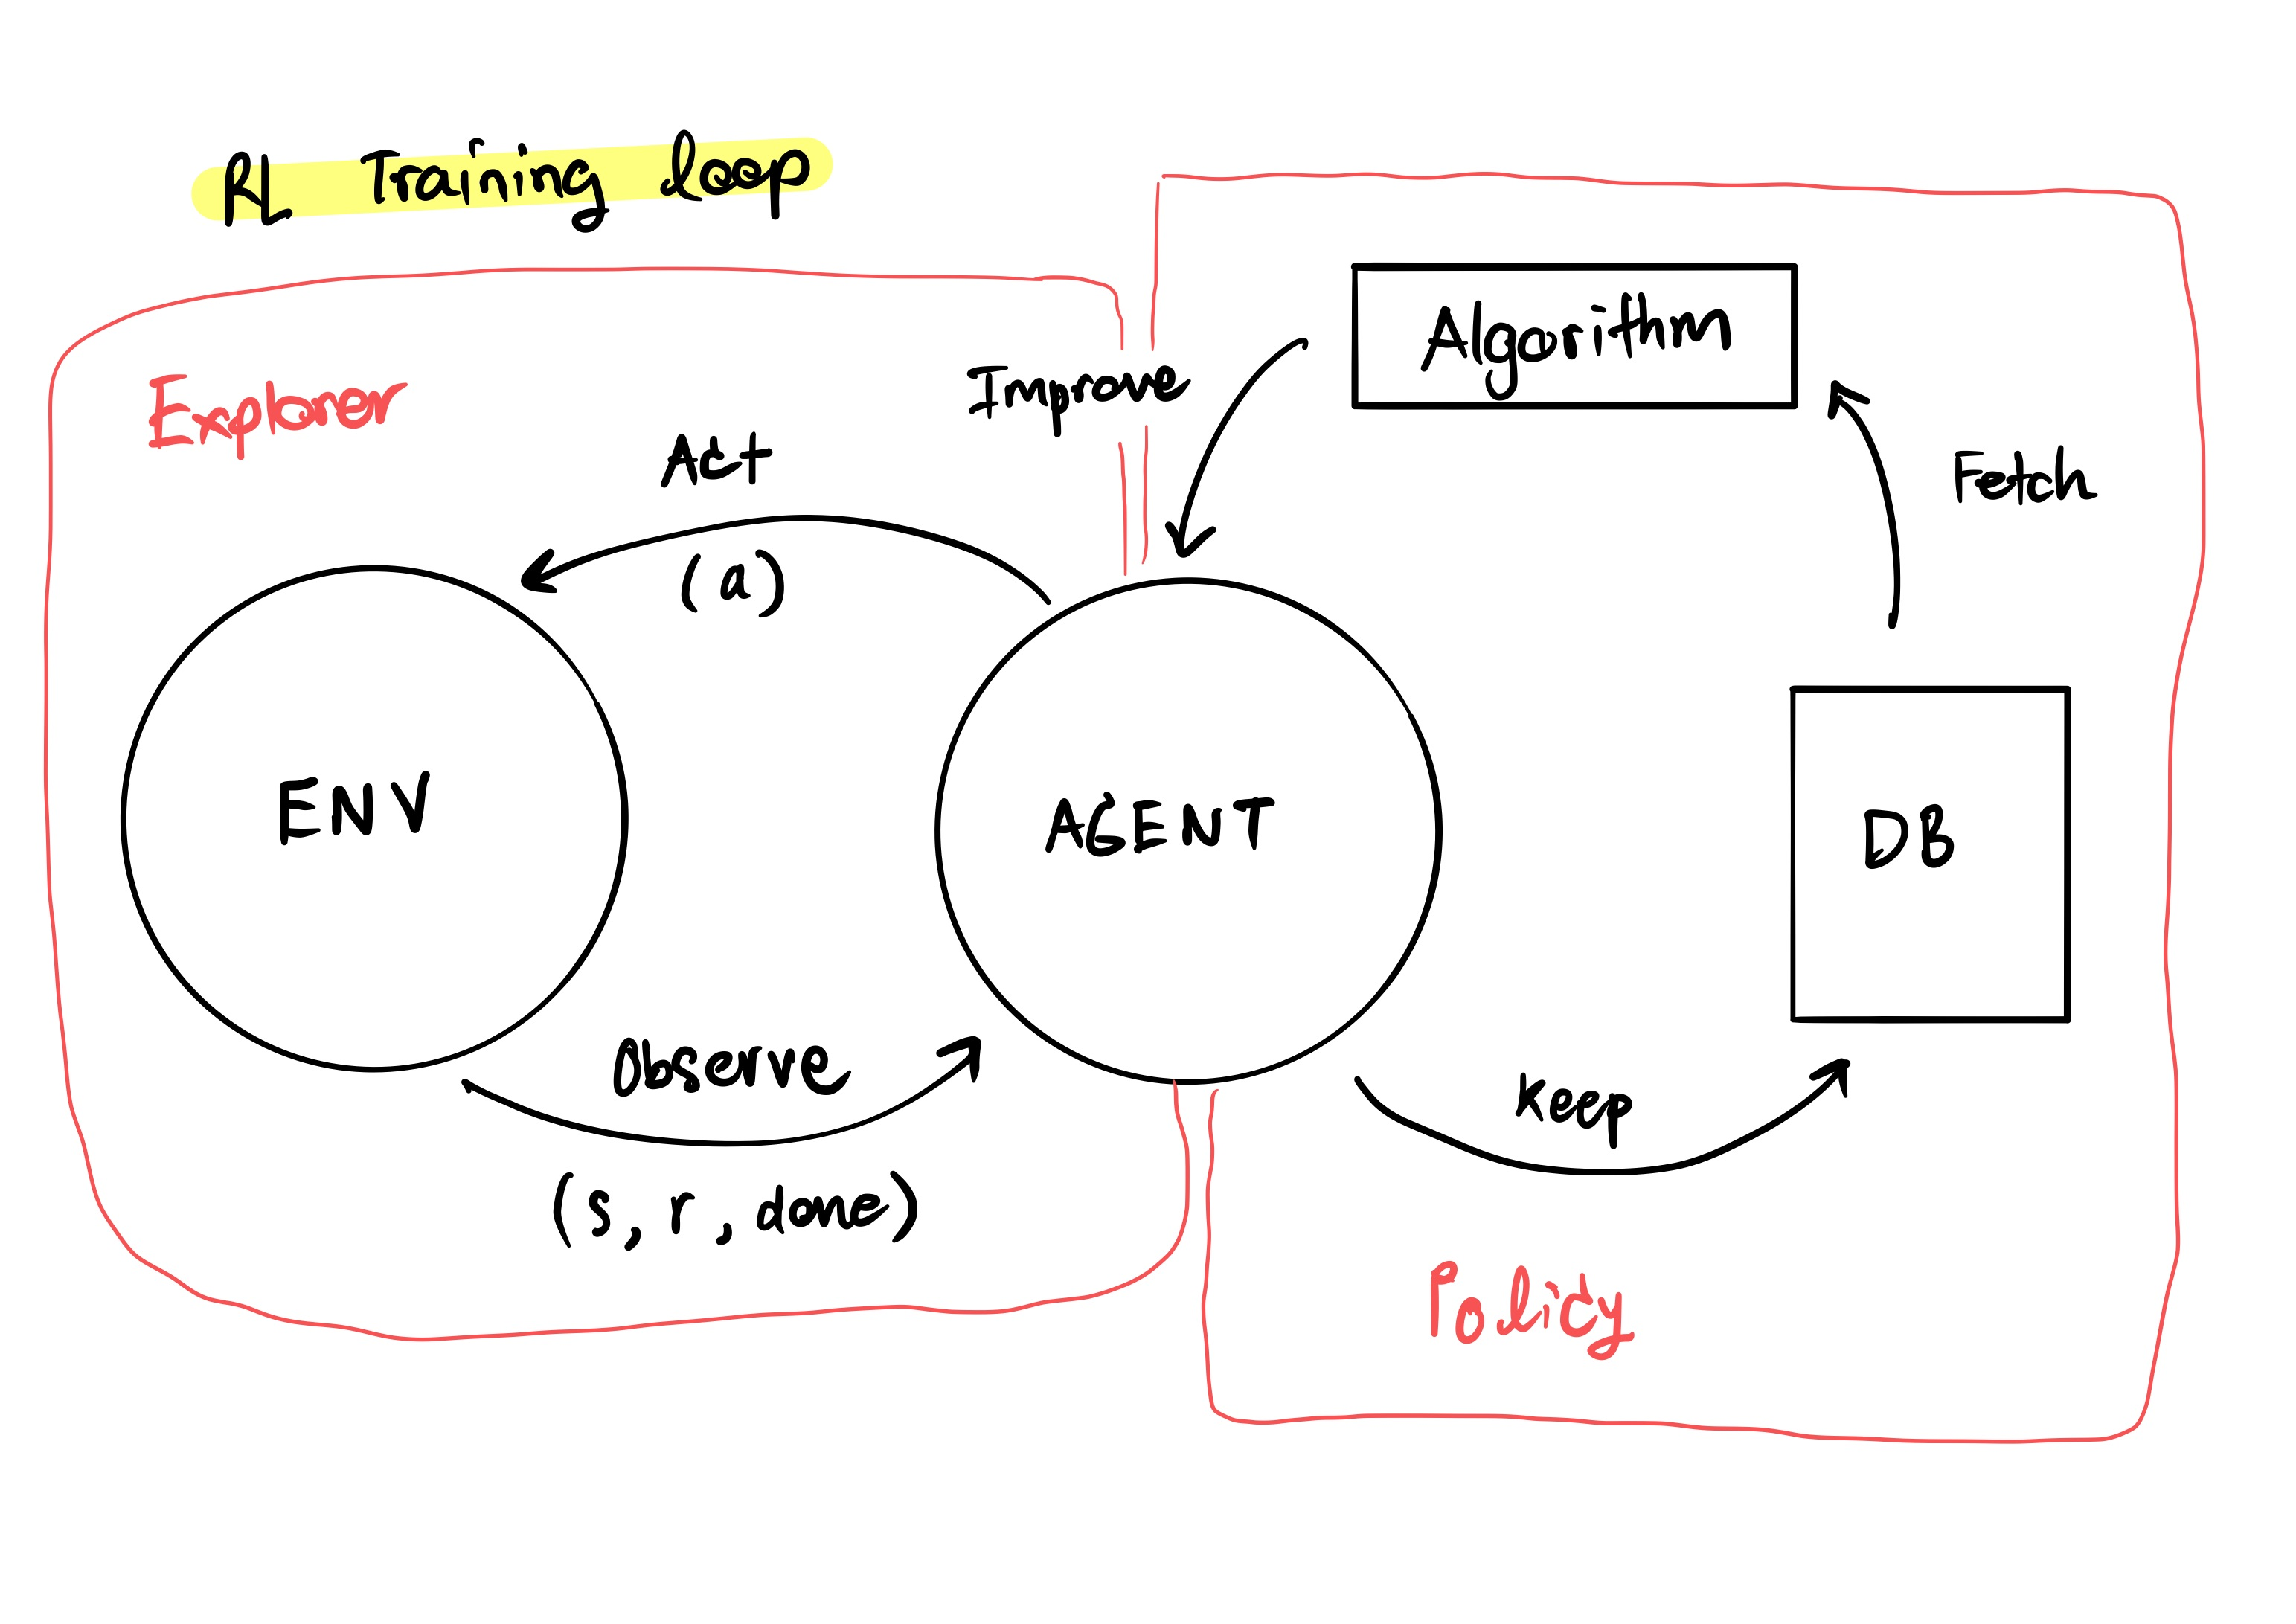

## Step 1: Make Env

In [2]:
def make_env():
    # define the environment here we use Gridworld
    env = rl.env.Gridworld(shape=(4, 3),
                           start=(2, 0),
                           goal=(1, 2),
                           move_reward=-1)
    env = rl.env.wrapper.ClipEpisodeLength(env, n_max_length=10)
    env = rl.env.wrapper.EpisodeSummary(env)
    return env

## Step 2: Define policy

### rl.policy.BasePolicy

You extend any RL agent from this class.

An RL agent needs to have two methods:

1. `step(state) -> action` will be called from the outside, an agent will return a desired action.
2. `optimize_step(data)` will be called from the outside, proper dataset will be fed, agent needs to update itself.

### Random agent example

In [7]:
import random

class RandomPolicy(rl.policy.BasePolicy):
    def __init__(self, n_action: int):
        self.n_action = n_action
    
    def step(self, state):
        # code here ...
        # taking a random action
        return random.randrange(self.n_action)
    
    def optimize_step(self, data):
        """random policy doesn't need to optimize"""
        raise NotImplementedError()
    

Test a random policy

In [8]:
env = make_env()
policy = RandomPolicy(env.action_space.n)
for i in range(3):
    print(policy.step(None))

2
3
3


Expected result: random actions, each number < 4

Test in an environment

In [10]:
env = make_env()
avg_reward = []
for i in range(1000):
    s = env.reset()
    while True:
        a = policy.step(s)
        s, r, done, info = env.step(a)
        if done:
            avg_reward.append(info['episode']['reward'])
            break
            
print('average sum of reward:', np.array(avg_reward).mean())

average sum of reward: -10.478


Expected result: around -11 reward

## Step 3: Define an explorer

Here we'll use an `rl.explorer.EpisodeExplorer` which is predefined for you 🙂.

In [11]:
explorer = rl.explorer.EpisodeExplorer(n_max_interaction=100, env=env)

In [12]:
data = explorer.step(policy)

In [13]:
data.keys()

dict_keys(['s', 'a', 'r', 'done'])

In [14]:
data['s']

[array([2, 0]),
 array([1, 0]),
 array([2, 0]),
 array([1, 0]),
 array([0, 0]),
 array([1, 0]),
 array([1, 0]),
 array([1, 1]),
 array([2, 1]),
 array([2, 0])]

In [15]:
data['a']

[0, 2, 0, 0, 2, 1, 3, 2, 1, 2]

In [16]:
data['r']

[-1, -1, -1, -1, -1, -1, -6, -1, -1, -1]

In [17]:
data['done']

[False, False, False, False, False, False, False, False, False, True]

# Q1: What does rl.explorer.EpisodeExplorer do?

Describe here ...
นำ environment ไปสร้างเป็น class explorer โดยเมื่อทำการ train จะบอกค่าของ state reward และ action ของแต่ละรอบออกมา

# The training loop

An RL algorithm is composed of two phases:

- Explore
- Optimize

Since our policy is a random policy there is no need for optimize, anyways it would look like this:

```
while True:
    try: 
        data = explorer.step(policy)
        policy.optimize_step(data) 
    except rl.exception.InteractionExceeded:
        break
```

# Q2: If we want to apply the above loop on a policy which optimizes every one step (instead of one episode), where should we make a change to realize that? How? Describe it briefly.

Describe here ...
1. แก้ไข fucnction optimize_step ใน class policy ให้สามารถ update policy ได้
2. ทำการ explorer data จะได้ data ออกมา
3. เอา data ที่ได้ไปใส่ใน fuction optimize_step ของ policy